(nb_seb)=
# Surface energy balance

In this exercise, we will use **pandas**, **xarray**, **MetPy**, **plotly**, and **rosely** to analyze weather station data from a csv file. We will perform data cleaning, manipulation, and visualization to gain insights into the data and explore its characteristics.


<div class="alert alert-block alert-success">
<b>Learning objectives:</b><br>
<ul>
 <li>Get familiar with weather station data</li>
 <li>Quality assessment of measurement time series</li>
 <li>Data resampling</li>
 <li>Visualisation with interactive plots</li>
</ul>  
</div>

<div class="alert alert-block alert-info">
<b>Prerequisites</b><br>
<ul>
<li>Basic knowledge of Python, Jupyter Notebooks, and data analysis</li>
<li>Familiarity with MetPy, Pandas, and Xarray</li>
    <li>The additional packages <b>rosely</b> and <b>plotly</b> must be installed
<li>A csv file containing weather station data (can also be downloaded <a href="https://github.com/sauterto/clim_env_hydro/blob/main/docs/nb/data/FLX_CH-Dav_missing.csv" download>here</a>)</li>
</ul>  
</div>

In [14]:
import numpy as np
import pandas as pd
import math

# Import the plotly library
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from hu_tools import HU_learning_material

#-----------------------------
# Load the learning materials
#-----------------------------
hu = HU_learning_material()

# Solar parameters and transmissivity

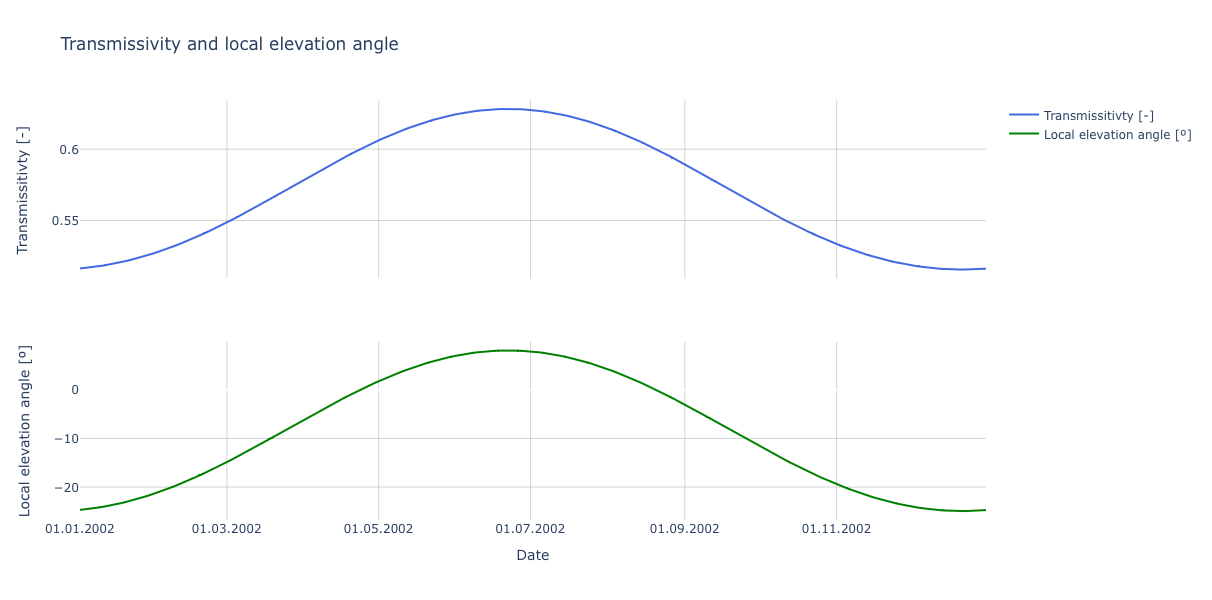

In [43]:
#----------------------
# Parameters
#----------------------
ch = 0.0    # High cloud fraction
cm = 0.0    # Middle cloud fraction
cl = 0.0    # Low cloud fraction
lat = 45.0  # Latitude of location
lon = 10.0  # Longitud of location
UTC = 19.5  # UTC at location

#------------------------------------
# Calc parameters and tranmissivity
#------------------------------------
# Create a date vector for which the solar parameters and transmisivity are calculated
timestamp = pd.date_range(start='01-01-2002', end='31-12-2002', freq='D')

# Calculate transmissivity using th HU-Tools
data  = hu.tau(ch, cm, cl, lat, lon, UTC, timestamp.dayofyear, 173, timestamp.size)

# Local elevation angle using th HU-Tools
angle = np.rad2deg(np.arcsin(hu.local_elevation_angle(lat,lon,UTC,timestamp.dayofyear,173,timestamp.size)))

# Create a pandas DataFrame from the calculated arrays and the date vector
df = pd.DataFrame(data, index=timestamp, columns=['tau'])

# Add the local elevation angle to the DataFrame
df['angle'] = angle

#----------------------
# Plot the results
#----------------------
# Creating the plot with two rows and one column. The plots share the same x-axis so that only labels 
# for the lower plots are shown
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)

# Adding the temperature data as a dashed line in the top panel
fig.add_trace(go.Scatter(x=df.index, y=df.tau, line=dict(color='royalblue', dash='solid'), name='Transmissitivty [-]'),
                        row=1, col=1)

# Adding the precipitation data as a dashed line in the bottom panel
fig.add_trace(go.Scatter(x=df.index, y=df.angle, line=dict(color='green', dash='solid'), name='Local elevation angle [º]'),
                         row=2, col=1)

# Adjusting the layout
fig.update_layout(title='Transmissivity and local elevation angle', plot_bgcolor='white', width=800, height=600,
                  yaxis=dict(title='Transmissitivty [-]', showgrid=True, gridcolor='lightgray', gridwidth=1),
                  yaxis2=dict(title='Local elevation angle [º]', showgrid=True, gridcolor='lightgray', gridwidth=1),
                  xaxis=dict(title='', tickformat='%d.%m.%Y', showgrid=True, gridcolor='lightgray', gridwidth=1),
                  xaxis2=dict(title='Date', tickformat='%d.%m.%Y', showgrid=True, gridcolor='lightgray', gridwidth=1))


# Adjusting the axes
fig.update_xaxes(nticks=10, row=1, col=1)
fig.update_yaxes(nticks=5, row=1, col=1)
fig.update_xaxes(nticks=10, row=2, col=1)
fig.update_yaxes(nticks=5, row=2, col=1)

# Showing the plot
fig.show()

<div class="alert alert-block alert-warning">
<b>Broaden Knowledge & Comprehension</b></br>
In what period of time is the sun still above the horizon at 45º north and 10º east after 7:30pm?
How sensitive is the transmissivity to clouds in the low, middle and high atmosphere? Look at the equation for transmissivity and find out why there are differences. What is a weakness of the parameterisation?
</div>

# Shortwave radiation and albedo

In [44]:
albedo = 0.7  # [-] 
SWin = 342    # W/mˆ2

print('Incoming shortwave radiation: {:.2f}'.format(SWin))
print('Outgoing shortwave radiation: {:.2f}'.format(hu.SWout(SWin,albedo)))

Incoming shortwave radiation: 342.00
Outgoing shortwave radiation: 239.40


<div class="alert alert-block alert-warning">
<b>Broaden Knowledge & Comprehension</b></br>
Review the 'Global Energy Fluxes' figure on slide 4 of the presentation and identify the outgoing shortwave radiation. Use this information to determine the global albedo.
</div>


In [187]:
import numpy as np
import metpy.calc
from metpy.units import units
import math

# The following functions are needed for radiation method Moelg2009
def solpars(lat):
    """ Calculate time correction due to orbital forcing (Becker 2001)
     and solar parameters that vary on daily basis (Mölg et al. 2003)
     0: day angle (rad); 1: in (deg); 2: eccentricity correction factor;
     3: solar declination (rad); 4: in (deg); 5: sunrise hour angle; 6: day length
    """

    timecorr = np.zeros((366, 4))
    solpars = np.zeros((366, 7))

    for j in np.arange(0, 365):
        # Time correction
        x = 0.9856 * (j + 1) - 2.72
        T2 = -7.66 * math.sin(math.radians(x)) - 9.87 * math.sin(
            2 * math.radians(x) + math.radians(24.99) + math.radians(3.83) * math.sin(math.radians(x)))
        timecorr[j, 0] = j + 1  # Julian Day
        timecorr[j, 1] = x
        timecorr[j, 2] = T2  # Time difference between True Local Time (TLT) and Average Local Time (ALT)
        timecorr[j, 3] = T2 * 15 / 60  # Time difference in deg (15°/h)

        # Solar parameters
        tau = 2 * math.pi * (j) / 365
        solpars[j, 0] = tau
        solpars[j, 1] = tau * 180 / math.pi
        solpars[j, 2] = 1.00011 + 0.034221 * math.cos(tau) + 0.00128 * math.sin(tau) + 0.000719 * math.cos(2*tau) + 0.000077 * math.sin(2 * tau)
        solpars[j, 3] = 0.006918 - 0.399912 * math.cos(tau) + 0.070257 * math.sin(tau) - 0.006758 * math.cos(2*tau) + 0.000907 * math.sin(2 * tau) - 0.002697 * math.cos(3 * tau) + 0.00148 * math.sin(3 * tau)
        solpars[j, 4] = solpars[j, 3] * 180 / math.pi
        solpars[j, 5] = math.acos(-math.tan(lat * math.pi / 180) * math.tan(solpars[j, 3])) * 180 / math.pi
        solpars[j, 6] = 2 / 15 * solpars[j, 5]

    # Duplicate line 365 for years with 366 days
    solpars[365, :] = solpars[364, :]
    timecorr[365, :] = timecorr[364, :]

    return solpars, timecorr


def haversine(lat1, lon1, lat2, lon2):
    """ This function calculates the distance between two points given their longitudes and latitudes
     based on the haversine formula. """

    lat1_rad = math.radians(lat1)
    lat2_rad = math.radians(lat2)
    lon1_rad = math.radians(lon1)
    lon2_rad = math.radians(lon2)
    delta_lat = lat2_rad - lat1_rad
    delta_lon = lon2_rad - lon1_rad
    a = ((math.sin(delta_lat / 2)) ** 2 + math.cos(lat1_rad) * math.cos(lat2_rad) * (math.sin(delta_lon / 2)) ** 2) ** 0.5
    d = 2 * 6371000 * math.asin(a)
    return d


def relshad(dem, mask, lats, lons, solh, sdirfn):
    """ This function calculates the topographic shading based on Mölg et al. 2009
     Input:
           dem:    A DEM of the study region, that also includes surrounding terrain
           mask:   A glacier mask
           lats:   The latitudes
           lons:   The longitudes
           solh:   The solar elevation (degrees)
           sdirfn: The illumination direction (in degrees from north)
     Output:
           illu:   Grid illu containing 0 = shaded, 1 = in sun
    """

    z = dem
    illu = dem * 0.0  # create grid that will be filled
    illu[:, :] = np.nan

    # Define maximum radius (of DEM area) in degreees lat/lon
    rmax = ((np.linalg.norm(np.max(lats) - np.min(lats))) ** 2 + (np.linalg.norm(np.max(lons) - np.min(lons))) ** 2) ** 0.5
    nums = abs(int(rmax * len(lats) / (lats[0] - lats[-1])))

    # Calculate direction to sun
    beta = math.radians(90 - sdirfn)
    dy = math.sin(beta) * rmax  # walk into sun direction (y) as far as rmax
    dx = math.cos(beta) * rmax  # walk into sun direction (x) as far as rmax

    # Extract profile to sun from each (glacier) grid point
    for ilat in np.arange(1, len(lats) - 1, 1):
        for ilon in np.arange(1, len(lons) - 1, 1):
            if mask[ilat, ilon] == 1:
                start = (lats[ilat], lons[ilon])
                targ = (start[0] + dy, start[1] + dx)  # find target position

                # Points along profile (lat/lon)
                lat_list = np.linspace(start[0], targ[0], nums)  # equally spread points along profile
                lon_list = np.linspace(start[1], targ[1], nums)  # equally spread points along profile

                # Don't walk outside DEM boundaries
                lat_list_short = lat_list[(lat_list < max(lats)) & (lat_list > min(lats))]
                lon_list_short = lon_list[(lon_list < max(lons)) & (lon_list > min(lons))]

                # Cut to same extent
                if (len(lat_list_short) > len(lon_list_short)):
                    lat_list_short = lat_list_short[0:len(lon_list_short)]
                if (len(lon_list_short) > len(lat_list_short)):
                    lon_list_short = lon_list_short[0:len(lat_list_short)]

                # Find indices (instead of lat/lon) at closets gridpoint
                idy = (ilat, (np.abs(lats - lat_list_short[-1])).argmin())
                idx = (ilon, (np.abs(lons - lon_list_short[-1])).argmin())

                # Points along profile (indices)
                y_list = np.round(np.linspace(idy[0], idy[1], len(lat_list_short)))
                x_list = np.round(np.linspace(idx[0], idx[1], len(lon_list_short)))

                # Calculate ALTITUDE along profile
                zi = z[y_list.astype(int), x_list.astype(int)]

                # Calclulate DISTANCE along profile
                d_list = []
                for j in range(len(lat_list_short)):
                    lat_p = lat_list_short[j]
                    lon_p = lon_list_short[j]
                    dp = haversine(start[0], start[1], lat_p, lon_p)
                    d_list.append(dp)
                distance = np.array(d_list)

                # Topography angle
                Hang = np.degrees(np.arctan((zi[1:len(zi)] - zi[0]) / distance[1:len(distance)]))

                if np.max(Hang) > solh:
                    illu[idy[0], idx[0]] = 0
                else:
                    illu[idy[0], idx[0]] = 1

    return illu


def LUTshad(solpars, timecorr, lat, elvgrid, maskgrid, lats, lons, STEP, TCART):
    """ This function calculates the look-up-table for topographic shading for one year.
     Input:
           solpars:   Solar parameters
           timecorr:  Time correction due to orbital forcing
           lat:       Latitude at AWS
           elvgrid:   DEM
           maksgrid:  Glacier mask
           lats:      Latitudes
           lons:      Longitudes
           STEP:      Time step (s)
           TCART:     Time correction due to difference MLT - TLT
     Output:
           shad1yr:   Look-up-table for topographic shading for 1 year
    """

    hour = np.arange(1, 25, 1)
    shad1yr = np.zeros((int(366 * (3600 / STEP) * 24), len(lats), len(lons)))  # Array (time,lat,lon)
    shad1yr[:, :, :] = np.nan

    # Go through days of year
    for doy in np.arange(0, 366, 1):

        soldec = solpars[doy, 3]  # solar declination (rad)
        eccorr = solpars[doy, 2]  # eccenctricy correction factor
        tcorr = timecorr[doy, 3]  # time correction factor (deg)

        # Go through hours of day
        for hod in np.arange(0, 24, int(STEP / 3600)):

            # calculate solar geometries
            stime = 180 + (15 / 2) - hod * 15 - tcorr + TCART
            sin_h = math.sin(soldec) * math.sin(lat * math.pi / 180) + math.cos(soldec) * math.cos(lat * math.pi / 180) * \
                    math.cos(stime * math.pi / 180)
            cos_sol_azi = (sin_h * math.sin(lat * math.pi / 180) - math.sin(soldec)) / math.cos(math.asin(sin_h)) / \
                    math.cos(lat * math.pi / 180)

            if stime > 0:
                solar_az = math.acos(cos_sol_azi) * 180 / math.pi
            else:
                solar_az = math.acos(cos_sol_azi) * 180 / math.pi * (-1)

            solar_h = math.asin(sin_h) * 180 / math.pi

            sdirfn = 180 - solar_az

            # Calculation (1 = in sun, 0 = shaded, -1 = night)
            if sin_h > 0.01:
                illu = relshad(elvgrid, maskgrid, lats, lons, solar_h, sdirfn)
                shad1yr[round(doy * (3600 / STEP) * 24 + (hod * 3600 / STEP)), maskgrid == 1] = illu[maskgrid == 1]
            else:
                shad1yr[round(doy * (3600 / STEP) * 24 + (hod * 3600 / STEP)), maskgrid == 1] = -1.0

    return shad1yr


def LUTsvf(elvgrid, maskgrid, slopegrid, aspectgrid, lats, lons):
    """ This function calculates the look-up-table for the sky-view-factor for one year.
     Input:
           elvgrid:   DEM
           maksgrid:  Glacier mask
           slopegrid: Slope
           aspectgrid:Aspect
           lats:      Latitudes
           lons:      Longitudes
    """

    slo = np.radians(slopegrid)
    asp = np.radians(aspectgrid)
    res = elvgrid * 0
    count = 0
        
    # Go through all directions (0-360°)
    for azi in np.arange(10, 370, 10):
        # Go through all elevations (0-90°)
        for el in np.arange(2, 90, 2):
            illu = relshad(elvgrid, maskgrid, lats, lons, el, azi)
            a = ((math.cos(np.radians(el)) * np.sin(slo) * np.cos(asp - np.radians(azi))) + (np.sin(np.radians(el)) * np.cos(slo)))
            a[a < 0] = 0
            a[a > 0] = 1
            a[illu == 0] = 0
            res = res + a
            count = count + 1

    vsky = elvgrid * 0
    vsky[:, :] = np.nan
    vsky[maskgrid == 1] = res[maskgrid == 1] / (36 * 44)

    return vsky


def calcRad(solPars, timecorr, doy, hour, lat, tempgrid, pgrid, rhgrid, cldgrid, elvgrid, maskgrid, slopegrid,
            aspectgrid, shad1yr, gridsvf, STEP, TCART):
    """ This function computes the actual calculation of solar Radiation (direct + diffuse)
     including corrections for topographic shading and self-shading, based on Mölg et al. 2009, Iqbal 1983, Hastenrath 1984.
     Input:
           solpars:   Solar parameters
           timecorr:  Time correction due to orbital forcing
           doy:       Day of year
           hour:      Hour of day
           lat:       Latitude at AWSi
           tempgrid:  Air Temperature
           pgrid:     Air Pressure
           rhgrid:    Relative Humidity
           cldgrid:   Cloud fraction
           elvgrid:   DEM
           maksgrid:  Glacier mask
           slopegrid: Slope
           aspectgrid:Aspect
           shad1yr:   LUT topographic shading
           gridsvf:   LUT Sky-view-factor
           STEP:      Time step (s)
           TCART:     Time correction due to difference MLT - TLT
     Output:
           swiasky:   All-sky shortwave radiation
"""

    # Constants
    Sol0 = 1367          # Solar constant (W/m2)
    aesc1 = 0.87764      # Transmissivity due to aerosols at sea level
    aesc2 = 2.4845e-5    # Increase of aerosol transmissivity per meter altitude
    alphss = 0.9         # Aerosol single scattering albedo (Zhao & Li JGR112), unity (zero) -> all particle extinction is due to scattering (absorption)
    dirovc = 0.00        # Direct solar radiation at overcast conditions (as fraction of clear-sky dir. sol. rad, e.g. 10% = 0.1)
    dif1 = 4.6           # Diffuse radiation as percentage of potenial clear-sky GR at cld = 0
    difra = 0.66         # Diffuse radiation constant
    Cf = 0.65            # Constant that governs cloud impact

    soldec = solPars[doy - 1, 3]  # Solar declination (rad)
    eccorr = solPars[doy - 1, 2]  # Cccenctricy correction factor
    tcorr = timecorr[doy - 1, 3]  # Time correction factor (deg)

    # Output files
    swiasky = elvgrid.copy() + np.nan
    swidiff = elvgrid.copy() + np.nan

    # Mixing ratio from RH and Pres
    mixing_interp = metpy.calc.mixing_ratio_from_relative_humidity(pgrid * units.hPa, tempgrid * units.kelvin, rhgrid * units.percent)
    vp_interp = np.array(metpy.calc.vapor_pressure(pgrid * units.hPa, mixing_interp))

    # Solar geometries
    stime = 180 + (STEP / 3600 * 15 / 2) - hour * 15 - tcorr + TCART
    sin_h = math.sin(soldec) * math.sin(lat * math.pi / 180) + math.cos(soldec) * math.cos(
        lat * math.pi / 180) * math.cos(stime * math.pi / 180)
    mopt = 35 * (1224 * (sin_h) ** 2 + 1) ** (-0.5)
    if sin_h < 0:
        mopt = np.nan

    if sin_h > 0.01:  # Calculations are only performed when sun is there

        # Direct & diffuse radiation under clear-sky conditions
        TOAR = Sol0 * eccorr * sin_h
        TAUr = np.exp((-0.09030 * ((pgrid / 1013.25 * mopt) ** 0.84)) * (
                    1.0 + (pgrid / 1013.25 * mopt) - ((pgrid / 1013.25 * mopt) ** 1.01)))
        TAUg = np.exp(-0.0127 * mopt ** 0.26)
        k_aes = aesc2 * elvgrid + aesc1
        k_aes[k_aes > 1.0] = 1.0  # Aerosol factor: cannot be > 1
        TAUa = k_aes ** (mopt)
        TAUaa = 1.0 - (1.0 - alphss) * (1 - pgrid / 1013.25 * mopt + (pgrid / 1013.25 * mopt) ** (1.06)) * (1.0 - TAUa)
        TAUw = 1.0 - 2.4959 * mopt * (46.5 * vp_interp / tempgrid) / ((1.0 + 79.034 * mopt * (46.5 * vp_interp / tempgrid)) **
                                                                      0.6828 + 6.385 * mopt * (46.5 * vp_interp / tempgrid))
        taucs = TAUr * TAUg * TAUa * TAUw

        sdir = Sol0 * eccorr * sin_h * taucs  # Direct solar radiation on horizontal surface, clear-sky
        Dcs = difra * Sol0 * eccorr * sin_h * TAUg * TAUw * TAUaa * (1 - TAUr * TAUa / TAUaa) / (
                    1 - pgrid / 1013.25 * mopt + (pgrid / 1013.25 * mopt) ** (1.02))  # Diffuse solar radiation, clear sky
        grcs = sdir + Dcs  # Potential clear-sky global radiatio∫n

        # Correction for slope and aspect (Iqbal 1983)
        cos_zetap1 = (np.cos(np.radians(slopegrid)) * np.sin(np.radians(lat)) - np.cos(np.radians(lat)) * np.cos(np.radians(180 - aspectgrid)) *
                      np.sin(np.radians(slopegrid))) * np.sin(soldec)
        cos_zetap2 = (np.sin(np.radians(lat)) * np.cos(np.radians(180 - aspectgrid)) * np.sin(np.radians(slopegrid)) +
                      np.cos(np.radians(slopegrid)) * np.cos(math.radians(lat))) * np.cos(soldec) * np.cos(stime * np.pi / 180)
        cos_zetap3 = np.sin(np.radians(180 - aspectgrid)) * np.sin(np.radians(slopegrid)) * np.cos(soldec) * np.sin(stime * np.pi / 180)
        cos_zetap = cos_zetap1 + cos_zetap2 + cos_zetap3

        # Clear-sky direct solar radiation at surface (aspect & slope corrected)
        swidir0 = Sol0 * eccorr * cos_zetap * taucs
        swidir0[cos_zetap < 0.0] = 0.0  # self-shaded cells set to 0
        illu = elvgrid * 0.0
        illu = shad1yr[int(((doy - 1) * (86400 / STEP)) + (hour / (STEP / 3600))), :, :]
        swidir0[illu == 0.0] = 0.0
        sdir[illu == 0.0] = 0.0

        # Correction for cloud fraction
        swidiff[cldgrid > 0.0] = grcs[cldgrid > 0.0] * (((100 - Cf * 100) - dif1) / 100 * cldgrid[cldgrid > 0.0] +
                                    (dif1 / 100)) * gridsvf[cldgrid > 0.0]  # diffuse amount as percentage of direct rad.
        swidiff[cldgrid == 0.0] = Dcs[cldgrid == 0.0] * gridsvf[cldgrid == 0.0]
        swiasky[:, :] = swidir0 * (1 - (1 - dirovc) * cldgrid) + swidiff  # all-sky solar radiation at surface

    else:
        TOAR = 0.0
        swiasky[maskgrid == 1] = 0 * elvgrid[maskgrid == 1]
        illu = 0.0 * elvgrid - 1

    swiasky_ud = swiasky[::-1, :]
 
    return swiasky_ud

In [19]:
import rasterio
from rasterio.plot import show
from osgeo import gdal
import xarray as xr
from xrspatial import slope, aspect
import rioxarray

dem = xr.open_dataset("./data/paine_dem.tif", engine="rasterio")

dem = dem.sel(y=slice(-50.93,-50.96), x=slice(-73.06,-73.00))
dem.to_netcdf('paine_dem.nc', engine='netcdf4')
#dem['band_data'][0,:,:].plot()

elvgrid = dem['band_data'][0,:,:].data
slopegrid = slope(dem['band_data'][0,:,:]).data
aspectgrid = aspect(dem['band_data'][0,:,:]).data


maskgrid = np.ones_like(aspectgrid)
lons = dem['band_data'].x.data
lats = dem['band_data'].y.data


#solpars_param, timecorr = solpars(lats[0])

# Sky view factor
#svf = LUTsvf(np.flipud(elvgrid), np.flipud(maskgrid), np.flipud(slopegrid), np.flipud(aspectgrid), lats[::-1], lons)
#print('Look-up-table sky view factor done')

# Topographic shading
#shad1yr = LUTshad(solpars_param, timecorr, lats[0], np.flipud(elvgrid), np.flipud(maskgrid), lats[::-1], lons, 3*3600, 0.0)
#print('Look-up-table topographic shading done')


In [72]:
import netCDF4 as nc

dtstep = 3*3600
tcart = 0

# Save look-up tables
Nt = int(366 * (3600 / dtstep) * 24)  # number of time steps
Ny = len(lats)  # number of latitudes
Nx = len(lons)  # number of longitudes

f = nc.Dataset('./data/LUT_Rad.nc', 'w')
f.createDimension('time', Nt)
f.createDimension('lat', Ny)
f.createDimension('lon', Nx)

LATS = f.createVariable('lat', 'f4', ('lat',))
LATS.units = 'degree'
LONS = f.createVariable('lon', 'f4', ('lon',))
LONS.units = 'degree'

LATS[:] = lats
LONS[:] = lons

shad = f.createVariable('SHADING', float, ('time', 'lat', 'lon'))
shad.long_name = 'Topographic shading'
shad[:] = shad1yr

SVF = f.createVariable('SVF', float, ('lat', 'lon'))
SVF.long_name = 'sky view factor'
SVF[:] = svf

f.close()

In [214]:
dem = xr.open_dataset("./data/paine_dem.tif", engine="rasterio")
dem = dem.sel(y=slice(-50.93,-50.96), x=slice(-73.06,-73.00))

dem.to_netcdf('./data/paine_dem.nc')

elvgrid = dem['band_data'][0,:,:]
slopegrid = slope(dem['band_data'][0,:,:])
aspectgrid = aspect(dem['band_data'][0,:,:])


maskgrid = xr.zeros_like(aspectgrid)
lons = elvgrid.x
lats = elvgrid.y

solpars_param, timecorr = solpars(lats[0])

# Calculate solar Parameters
solPars, timeCorr = solpars(lats[0])

print('Read in look-up-tables')
ds_LUT = xr.open_dataset('./data/LUT_Rad.nc')
shad1yr = ds_LUT.SHADING.values
svf = ds_LUT.SVF.values


Read in look-up-tables


Read in look-up-tables


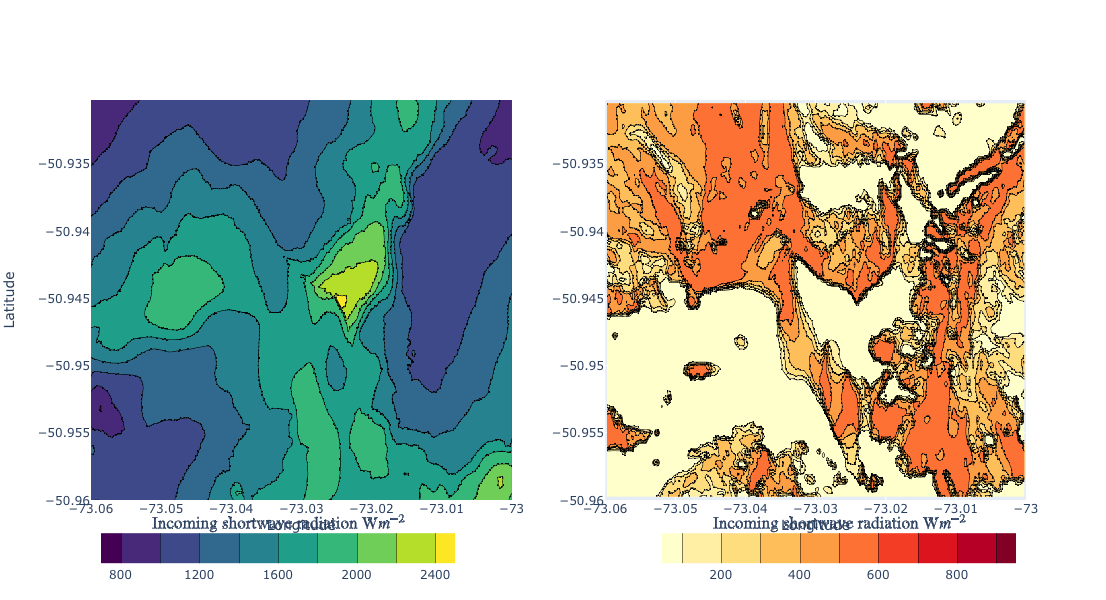

In [13]:
import plotly.graph_objects as go
import plotly.subplots as sp
import numpy as np
import xarray as xr
from xrspatial import slope, aspect

#------------------------------
# Read digital elevation model
#------------------------------
dem = xr.open_dataset('./data/paine_dem.nc')

# Read the elevation data from netcdf file
elvgrid = dem['band_data'][0,:,:]
# Read slope data
slopegrid = slope(dem['band_data'][0,:,:]).data
# Read aspect data
aspectgrid = aspect(dem['band_data'][0,:,:]).data

print('Read in look-up-tables')
ds_LUT = xr.open_dataset('./data/LUT_Rad.nc')
shad1yr = ds_LUT.SHADING.values
svf = ds_LUT.SVF.values

# Create additional arrays which are needed by the radiation module
# Temperature grid
tempgrid = np.ones_like(elvgrid) * 285.0
# Pressure grid
pgrid = np.ones_like(elvgrid) * 1000.0
# Relative humditiy grid
rhgrid = np.ones_like(elvgrid) * 70
# Cloud grid
ngrid = np.ones_like(elvgrid) * 0.0
# Mask grid (in case only part of the DEM is used
maskgrid = xr.zeros_like(elvgrid)

# Timestamp
lat = -50.9 # Latitude of the domain center
doy = 15    # Doy of the year
hour = 13   # Hour of the day
tcart = 0   
dtstep = 3*3600

# Get lon/lat values from the elevation model
lons = elvgrid.x
lats = elvgrid.y

#---------------------------
# Calculate solar Parameters
#---------------------------
solPars, timeCorr = hu.solpars(lats[0])

#---------------------------
# Calc radiation
#---------------------------
hu
A = hu.calcRad(solPars, timeCorr, doy, hour, lat, tempgrid[::-1, :], pgrid[::-1, :], rhgrid[::-1, :], 
        ngrid[::-1, :], np.flipud(elvgrid), np.flipud(maskgrid), np.flipud(slopegrid), np.flipud(aspectgrid), shad1yr, svf, dtstep, tcart)

#---------------------------
# Plot data
#---------------------------
# Generate sample data
x = lons
y = lats
X, Y = np.meshgrid(x, y)

# Create the subplots
fig = sp.make_subplots(rows=1, cols=2)

# Add the first subplot
fig.add_trace(go.Contour(x=x, y=y, z=elvgrid, colorscale='Viridis', showscale=True,
                         colorbar=dict(x=0.2, y=-0.22, len=0.4, yanchor='bottom', orientation='h',
                                      title=r'$\text{Incoming shortwave radiation}~\text{W} m^{-2}$', titleside='top')), row=1, col=1)

# Add the second subplot
fig.add_trace(go.Contour(x=x, y=y, z=A, colorscale='YlOrRd', showscale=True,
                         colorbar=dict(x=0.8, y=-0.22, len=0.4, yanchor='bottom', orientation='h', 
                                       title=r'$\text{Incoming shortwave radiation}~\text{W} m^{-2}$', titleside='top')), row=1, col=2)



# Add title and axis labels
fig.update_layout(
    xaxis=dict(title='Longitude',title_standoff=5),
    xaxis2=dict(title='Longitude',title_standoff=5),
    yaxis_title='Latitude',
    width=1200,  # Set the width of the figure
    height=600  # Set the height of the figure
)

# Show the plot
fig.show()

# Longwave radiation

In [ ]:
# Define a emissivity
epsilon = 1.0

# Radiated energy at zero degrees celcius
print('Radiated energy at zero degrees celcius: {:.4}'.format(hu.LW(epsilon, 273)))

# Wave length of emission maximum
print('Wave length of emission maximum: {:.4}'.format(hu.lambda_max(273)))

<div class="alert alert-block alert-success">
<b>Evaluate and Analyze</b><br>
<ul>
<li>Calculate the long-wave radiation for different temperatures. What is the relationship between temperature and radiated energy? [Hint: Take a look at the Stephan-Boltzmann Law]
<li>Plot the wavelength of the emission maximum against the radiated energy in the range from 250 K to 310 K. Which gases absorb in this spectral range? Comment on the influence of the most important gases on the greenhouse effect?
</ul>
</div>

<div class="alert alert-block alert-warning">
<b>Broaden Knowledge & Comprehension</b></br>
What must be taken into account when measuring long-wave radiation in order to obtain reliable values?
</div>

# Ground heat flux and heat equation

In [ ]:
#-----------------------
# Boundary conditions
#-----------------------
Ts = 20.   # Temperature at the surface [K]
Tb = 5.    # Temperature at the bottom [K]
D  = 2.    # Depth [m]
Nz = 100   # Number of grid points in the vertical (soil)
dt = 60.   # time step [s]
t7200  = 7200  # integration time [s]
t86400 = 86400 # integration time [s]
alpha = 1.2e-6 # soil thermal diffusivity [m^2 s^-1]

#-----------------------
# Run the heat equation
#-----------------------
T, dz = hu.heat_equation_indices(Ts, Tb, D, Nz, t7200, dt, alpha)
T2, dz = hu.heat_equation(Ts, Tb, D, Nz, t86400, dt, alpha)

#-----------------------
# Make plots
#-----------------------
# Creating the plot with two rows and one column. The plots share the same x-axis so that only labels 
# for the lower plots are shown
fig = make_subplots(rows=1, cols=1, shared_yaxes=True)

# Adding the temperature data as a dashed line in the top panel
fig.add_trace(go.Scatter(x=T, y=-dz*np.arange(Nz), line=dict(color='royalblue', dash='solid'), name='Temperature after 7200 s'),
                        row=1, col=1)

# Adding the temperature data as a dashed line in the top panel
fig.add_trace(go.Scatter(x=T2, y=-dz*np.arange(Nz), line=dict(color='green', dash='solid'), name='Temperature after 86400'),
                        row=1, col=1)

# Adjusting the layout
fig.update_layout(title='Soil temperature', plot_bgcolor='white', width=800, height=600,
                  yaxis=dict(title='Depth [m]', showgrid=True, gridcolor='lightgray', gridwidth=1),
                  xaxis=dict(title='Temperature [K]', tickformat='%d.%m.%Y', showgrid=True, gridcolor='lightgray', gridwidth=1))


# Adjusting the axes
fig.update_xaxes(nticks=10, row=1, col=1, range=[-2,20], dtick=5)
fig.update_yaxes(nticks=5, row=1, col=1)

# Showing the plot
fig.show()

<div class="alert alert-block alert-success">
<b>Evaluate and Analyze:</b><br>
<ul>
 <li>What happens if the integration time is set to a very long period? </li>
 <li>How can the model be improved? What influence does soil thermal diffusivity have on the temperature profile?</li>
 <li>Take diffusivity values for different soil types from the literature and compare the different temperature profiles.</li>     
</ul>  
</div>

<div class="alert alert-block alert-warning">
<b>Broaden Knowledge & Comprehension</b></br>
How can the soil heat flux be determined from the temperature profile?
</div>

In [ ]:
#-----------------------------
# Create pandas dataframe with
# the surface temperature
#-----------------------------
# timestamp from/to
timestamp = pd.date_range(start='2001-01-01T00:00:00', end='2003-12-31T00:00:00', freq='D')

# Surrogate surface temperature timeseries
T = 10 - 20 * np.sin((2*math.pi*timestamp.dayofyear)/365)

# Create a pandas DataFrame from the calculated arrays
df = pd.DataFrame(T, index=timestamp, columns=['T'])

#-----------------------------
# Run the time-dependent heat
# equation
#-----------------------------
D  = 20   # Depth of the domain
dz = 0.5  # Spacing between grid points
T, D, dz = hu.heat_equation_daily(df['T'], D, dz, alpha=1.2e-6)

#-----------------------------
# Plot the results
#-----------------------------
# Generate the plotting grid
# y-axis values
y_values = np.arange(-D,0,dz)
# then the x-axis values
x_values = np.arange(len(df.index))
# Generate the 2D plotting grid
X, Y = np.meshgrid(x_values, y_values)

# Create the filled contour trace
trace = go.Contour(
    x=df.index,
    y=y_values,
    z=T[::-1],
    colorscale='Viridis',
    contours=dict(
        coloring='fill',
        showlabels=True
    ),
    colorbar=dict(
        title=dict(
            text='Temperature [ºC]',
            #standoff=15,
            side='right'
        )
    )
)

# Create the layout
layout = go.Layout(
    title='Soil temperature',
    xaxis=dict(title='Date', tickformat='%d.%m.%Y', tickangle=45, dtick='M3'),
    yaxis=dict(title='Depth [m]'),
    width=1000, height=500,
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()

<div class="alert alert-block alert-warning">
<b>Broaden Knowledge & Comprehension</b></br>
Change the soil thermal diffusivity and see how the profile changes. 
</div>


In [ ]:
# Creating the plot with two rows and one column. The plots share the same x-axis so that only labels 
# for the lower plots are shown
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

# Adding the temperature data as a dashed line in the top panel
fig.add_trace(go.Scatter(x=df.index, y=T[10,:], line=dict(color='royalblue', dash='solid'), name='5 m'),
                        row=1, col=1)

# Adding the temperature data as a dashed line in the top panel
fig.add_trace(go.Scatter(x=df.index, y=T[20,:], line=dict(color='orange', dash='solid'), name='10 m'),
                        row=1, col=1)

# Adjusting the layout
fig.update_layout(title='Soil temperature', plot_bgcolor='white', width=1000, height=600,
                  yaxis=dict(title='Soil temperature [K]', showgrid=True, gridcolor='lightgray', gridwidth=1),
                  xaxis=dict(title='', tickformat='%d.%m.%Y', showgrid=True, gridcolor='lightgray', gridwidth=1))


# Adjusting the axes
fig.update_xaxes(nticks=10, row=1, col=1, tickformat='%d.%m.%Y', tickangle=45, dtick='M3')
fig.update_yaxes(nticks=5, row=1, col=1)

# Showing the plot
fig.show()

In [ ]:
help(hu.emissivity)

## Load weather station data

In this example, the code reads in the 30-min weather stations data from a CSV file using the '**read_csv()**' method from pandas, with the parse_dates and index_col parameters set to True and 0, respectively. This ensures that the first column of the CSV file (the timestamps) is used as the index of the DataFrame, and that the timestamps are converted to datetime objects.

In [ ]:
import pandas as pd
import numpy as np

# Load CSV file
df = pd.read_csv("https://raw.githubusercontent.com/sauterto/clim_env_hydro/main/docs/nb/data/FLX_CH-Dav.csv", parse_dates=True, index_col=0)

# The file contains:
# Air temperature       :: t2m
# Relative humdity      :: RH
# Precipitation         :: precip
# Wind speed            :: WS
# Wind direction        :: WD
# Net radiation         :: NETRAD
# Incoming shortwave    :: SW_IN
# Outgoing shortwave    :: SW_OUT
# Incoming longwave     :: LW_IN
# Outgoing longwave     :: LW_OUT
# Sensible heat flux    :: H
# Latent heat flux      :: LE
# Ground heat flux      :: QG
# Surface temperature   :: TS

<div class="alert alert-block alert-warning">
<b>Broaden Knowledge & Comprehension</b></br>
Which other file formats can be read in with pandas?
</div>

## Replace missing data

Next, we want to view the data to ensure it has been loaded correctly. We use the head() method from Pandas to display the first five rows of the DataFrame.

The DataFrame has missing values with the dummy value -9999. We then use the replace method to replace all occurrences of -9999 with NaN (Not a Number), using the NumPy np.nan constant. Finally, we print the updated DataFrame. The inplace=True argument ensures that the original DataFrame is modified, rather than a copy being created.

In [ ]:
# replace -9999 with NaN
df.replace(-9999, np.nan, inplace=True)

# Keep only the surface temeperature
ds = df['TS']

# check for missing values
ds.dropna(inplace=True)

# Show time series
ds

<div class="alert alert-block alert-warning">
<b>Hint!</b> Compare the SW_OUT and LW_OUT column with those of the previous table.
</div>

To check for missing values in a Pandas DataFrame, you can use the **isna()** or **isnull()** method, which returns a Boolean DataFrame of the same shape indicating which cells contain missing values.

You can also use the isna() or isnull() method along with the **sum()** method to count the number of missing values in each column:

In [ ]:
# resample dataframe to monthly mean values with different aggregation for each column and return NaN for 
# columns with insufficient valid elements
threshold =  50 # What is the maximum percentage of NaNs that may be included in the averaging? Here, we set the threshold to 10%

# This is a pythonic way in solving this problem
ds_daily = ds.resample('1D').agg({'TS': lambda x: x.dropna().mean() if (((x.isna().sum())/len(x))*100) < threshold else np.nan})

# Find dates with missing data
missing_dates = ds_daily['TS'][ds_daily['TS'].isnull()].index
print("Dates with missing data:\n",ds_daily.loc[missing_dates])

# Check if the time series is continuous
if pd.date_range(start=ds_daily.index.min(), end=ds_daily.index.max(), freq='D').difference(ds_daily.index).empty:
    print('The time series is continuous \n')
else:
    print('The time series is not continuous \n')
    
# Plot the temperature time series
ds_daily['TS'].plot()

In [ ]:
#-----------------------------
# Load the learning materials
#-----------------------------
hu = HU_learning_material()

#-----------------------------
# Run the time-dependent heat
# equation
#-----------------------------
D  = 10   # Depth of the domain
dz = 0.5  # Spacing between grid points

df_hourly_subset = ds_daily.loc['2010':'2014']

T, D, dz = hu.heat_equation_daily(df_hourly_subset['TS'], D, dz, alpha=1.2e-6)

#-----------------------------
# Plot the results
#-----------------------------
# Generate the plotting grid
# y-axis values
y_values = np.arange(-D,0,dz)
# then the x-axis values
x_values = np.arange(len(df_hourly_subset.index))
# Generate the 2D plotting grid
X, Y = np.meshgrid(x_values, y_values)

# Create the filled contour trace
trace = go.Contour(
    x=df_hourly_subset.index,
    y=y_values,
    z=T[::-1],
    colorscale='Viridis',
    contours=dict(
        coloring='fill',
        showlabels=True
    ),
    colorbar=dict(
        title=dict(
            text='Temperature [ºC]',
            #standoff=15,
            side='right'
        )
    )
)

# Create the layout
layout = go.Layout(
    title='Soil temperature',
    xaxis=dict(title='Date', tickformat='%d.%m.%Y', tickangle=45, dtick='M3'),
    yaxis=dict(title='Depth [m]'),
    width=1000, height=500,
)

# Create the figure
fig = go.Figure(data=[trace], layout=layout)

# Show the plot
fig.show()